# Initial State / Ensemble Tests

The plan is to prepare some initial density matrix $\hat{\rho}_0$ which we will take from thermal DFT. Traditionally thermal (Mermin) DFT is formulated in the grand canonical ensemble (GCE), and one finds a density matrix which minimizes the grand potential $\Omega = U - TS -\mu N$, where $U=\langle H\rangle$, and $S = k_B \rho \log \rho$  In general the density matrix that minimizes $\Omega$ is the grand-canonical density matrix

$$ \hat{\rho} = \frac{1}{Z_\mathrm{GC}} \sum_{\eta=0}^{\infty} \sum_{I}^{N_I(\eta)} e^{-\beta (E_I(\eta)-\mu\eta)} |E_I(\eta)\rangle\langle E_I(\eta)| $$

where $E_I(\eta) (|E_I(\eta)\rangle)$ are eigensvalues (eigenstates) of the Hamiltonian $H$ in a given $\eta$-electron particle sector, and $Z_{\mathrm{GC}}$ is the partition function

Within KS-DFT the density matrix is found by minimizing the grand potential associated with a fictitious non-interacting system which yields the same density as our original interacting one (in the limit we know the exact (thermal) exchange correlation functional). As such, the density matrix for the KS-system takes on a familiar simple form for free electrons

\begin{equation}
    \hat{\rho}_0 = \frac{1}{Z_\mathrm{GC}^0} \sum_{\eta=0}^{\infty} \sum_{\{n\}\vert_\eta} e^{-\beta (\sum_{i\in\{\eta\}}\varepsilon_i-\mu)} |\{n\}\rangle\langle\{n\}|
\end{equation}

where $\varepsilon_i$ is a KS eigenvalue and the sum is over all possible occupations of $\eta$ orbitals within the (potentially infinitely-sized) basis.

The fact that KS-DFT is usually formulated in the GCE allows us to use certain simplifications including identifying Fermi factors which define our KS orbital occupations

$$ \langle \hat{n}_i\rangle = \frac{1}{e^{-\beta(\varepsilon_i-\mu)}+1} = f_i$$

and various thermodynamic relations can be simplified, like

$$ Z_{GC}^0 = \prod_i (1+e^{-\beta(\varepsilon_i-\mu)}) $$

etc.

Assuming the occupations from KS DFT are appropriate then the goal should be to prepare Eq. 1 from at least two different ways.

1. We can sample bit strings from Eq. 1 with probability proportional to the Boltzmann weight and then time evolve these states and finally average to obtain the appropriate expectation value.
2. We may be able to prepare a circuit which prepares the mean-field ensemble and then map this to first quantization. 

## Path 1. Question 1: How many samples are needed for a representive system 

In [15]:
# Let's read in the Carbon example provided by Sandia
import numpy as np
from mec_sandia.vasp_utils import read_vasp

ase_cell = read_vasp(f"../vasp_data/C_POSCAR")

In [17]:
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr
volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_carbon = len(np.where(ase_cell.get_atomic_numbers() == 6)[0])
# There is 1 hydrogen atom in the cell
num_elec = 1 + num_carbon * 4
from mec_sandia.vasp_utils import compute_wigner_seitz 
# Get the Wigner-Seitz radius
rs = compute_wigner_seitz(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))

Volume = 255.27133939199965 A^3
rs = 0.9289611708818379 bohr


In [21]:
# We see rs ~ 1 meaning the system system is quite dense.
# Next let's check the temperature
# We have two temperatures 10eV and 1eV
from ase.units import kB # eV / K
print("10 eV = {} K".format(10/kB))
print("1 eV = {} K".format(1/kB))

10 eV = 116045.22060401007 K
1 eV = 11604.522060401008 K


In [30]:
from mec_sandia.ueg import calc_theta_from_beta
from ase.units import Hartree

# Next we can look at Theta = T / TF to see if we're in the warm dense regime
T_Ha = 10 / Hartree
beta = 1.0 / T_Ha
theta_10 = calc_theta_from_beta(beta, rs)
print("10 eV => Theta = {}".format(theta_10))
T_Ha = 1 / Hartree
beta = 1.0 / T_Ha
theta_1 = calc_theta_from_beta(beta, rs)
print("1 eV => Theta = {}".format(theta_1))
# We see that Theta is not negligeable => Warm dense regime.

10 eV => Theta = 0.17220781705309057
1 eV => Theta = 0.017220781705309055


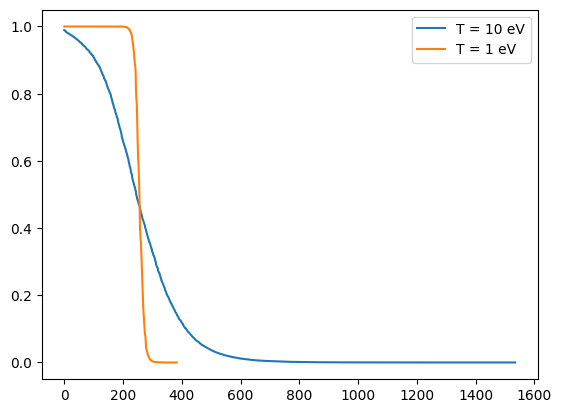

In [43]:
# Let's check the number of samples to converge say the occupancies to within x percent in the initial density matrix. 

from mec_sandia.vasp_utils import read_kohn_sham_data
import matplotlib.pyplot as plt

# 1. First read the KS data
eigs_10eV, occs_10eV = read_kohn_sham_data("../vasp_data/C_10eV_EIGENVAL")
eigs_1eV, occs_1eV = read_kohn_sham_data("../vasp_data/C_1eV_EIGENVAL")
plt.plot(occs_10eV, label="T = 10 eV", color="C0")
plt.plot(occs_1eV, label="T = 1 eV", color="C1")
plt.legend()

In [ ]:
# Now let's see how many states are required to reproduce these occupancies.



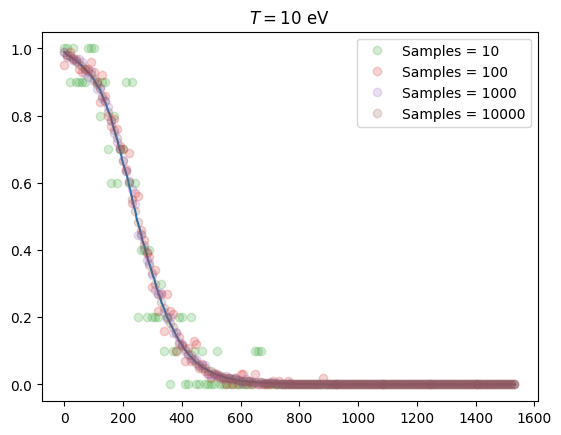

In [52]:
from mec_sandia.density_matrix import DensityMatrix
for isamp, num_samples in enumerate([10, 100, 1000, 10000]): 
    dm_10eV = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
    occs, errs = dm_10eV.compute_occupations()
    occ_a, err_a = occs[::2], errs[::2]
    ixs = np.arange(len(occ_a))
    plt.errorbar(ixs[::10], occ_a[::10], yerr=err_a[::10], lw=0, alpha=0.2, marker="o", color=f"C{isamp+2}", label=f"Samples = {num_samples}")
plt.legend()
plt.title("$T=10$ eV")
plt.plot(occs_10eV, label="KS-DFT", color="C0")

Text(0.5, 1.0, '$T=10$ eV')

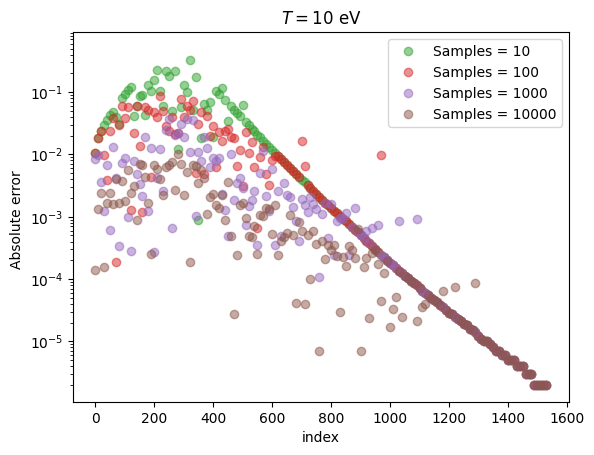

In [60]:

from mec_sandia.density_matrix import DensityMatrix
for isamp, num_samples in enumerate([10, 100, 1000, 10000]): 
    dm_10eV = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
    occs, errs = dm_10eV.compute_occupations()
    occ_a, err_a = occs[::2], errs[::2]
    ixs = np.arange(len(occ_a))
    plt.errorbar(ixs[::10], np.abs((occ_a[::10]-occs_10eV[::10])), yerr=err_a[::10], lw=0, alpha=0.5, marker="o", color=f"C{isamp+2}", label=f"Samples = {num_samples}")
plt.legend()
plt.ylabel("Absolute error ")
plt.yscale("log")
plt.xlabel("index")
plt.title("$T=10$ eV")

Text(0.5, 1.0, '$T=10$ eV')

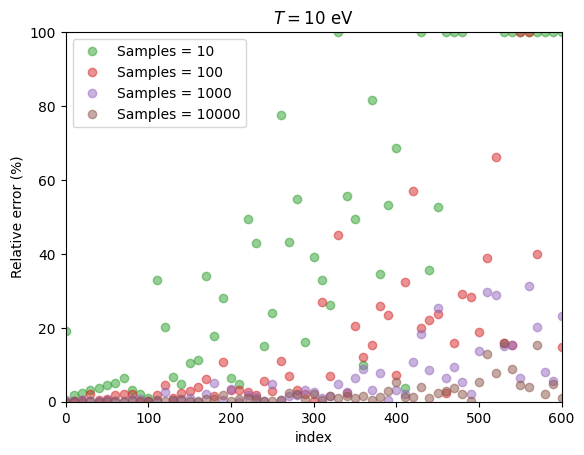

In [63]:
from mec_sandia.density_matrix import DensityMatrix
for isamp, num_samples in enumerate([10, 100, 1000, 10000]): 
    dm_10eV = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
    occs, errs = dm_10eV.compute_occupations()
    occ_a, err_a = occs[::2], errs[::2]
    ixs = np.arange(len(occ_a))
    plt.errorbar(ixs[::10], 100*np.abs((occ_a[::10]-occs_10eV[::10]))/occs_10eV[::10], yerr=err_a[::10], lw=0, alpha=0.5, marker="o", color=f"C{isamp+2}", label=f"Samples = {num_samples}")
plt.legend()
plt.ylabel("Relative error (%)")
plt.ylim([0, 100])
plt.xlim([0, 600])
plt.xlabel("index")
plt.title("$T=10$ eV")

In [64]:
# Look at error in "one-body energy"
from mec_sandia.density_matrix import DensityMatrix
one_body = []
one_body_err = []
samples = [10, 100, 1000, 10000]
for isamp, num_samples in enumerate(samples): 
    dm_10eV = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
    e1b, err = dm_10eV.contract_diagonal_one_body(eigs_10eV)
    one_body.append(e1b)
    one_body_err.append(err)

e1b_ref = 2 * np.einsum("i,i->", occs, eigs_10eV)
plt.axhline(e1b_ref)
plt.errorbar(samples, one_body, yerr=one_body_err, fmt="o")


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3072,)->(3072,) (1536,)->(1536,) 

## Path 1. Question 2: How large are Ensemble Effects?

## Path 2: Question 1: Can we discard states for fixed particle number simulation?

## Path 2: Question 2: How does the quantum circuit work?


TODO: Proof of concept cirq implementation?
